In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm

**Module** is an abstract class which defines fundamental methods necessary for a training a neural network. You do not need to change anything here, just read the comments.

In [4]:
class Module(object):
    """
    Basically, you can think of a module as of a something (black box)
    which can process `input` data and produce `ouput` data.
    This is like applying a function which is called `forward`:

        output = module.forward(input)

    The module should be able to perform a backward pass: to differentiate the `forward` function.
    More, it should be able to differentiate it if is a part of chain (chain rule).
    The latter implies there is a gradient from previous step of a chain rule.

        gradInput = module.backward(input, gradOutput)
    """
    def __init__ (self):
        self.output = None
        self.gradInput = None
        self.training = True

    def forward(self, input):
        """
        Takes an input object, and computes the corresponding output of the module.
        """
        return self.updateOutput(input)

    def backward(self,input, gradOutput):
        """
        Performs a backpropagation step through the module, with respect to the given input.

        This includes
         - computing a gradient w.r.t. `input` (is needed for further backprop),
         - computing a gradient w.r.t. parameters (to update parameters while optimizing).
        """
        self.updateGradInput(input, gradOutput)
        self.accGradParameters(input, gradOutput)
        return self.gradInput


    def updateOutput(self, input):
        """
        Computes the output using the current parameter set of the class and input.
        This function returns the result which is stored in the `output` field.

        Make sure to both store the data in `output` field and return it.
        """

        # The easiest case:

        # self.output = input
        # return self.output

        pass

    def updateGradInput(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own input.
        This is returned in `gradInput`. Also, the `gradInput` state variable is updated accordingly.

        The shape of `gradInput` is always the same as the shape of `input`.

        Make sure to both store the gradients in `gradInput` field and return it.
        """

        # The easiest case:

        # self.gradInput = gradOutput
        # return self.gradInput

        pass

    def accGradParameters(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own parameters.
        No need to override if module has no parameters (e.g. ReLU).
        """
        pass

    def zeroGradParameters(self):
        """
        Zeroes `gradParams` variable if the module has params.
        """
        pass

    def getParameters(self):
        """
        Returns a list with its parameters.
        If the module does not have parameters return empty list.
        """
        return []

    def getGradParameters(self):
        """
        Returns a list with gradients with respect to its parameters.
        If the module does not have parameters return empty list.
        """
        return []

    def train(self):
        """
        Sets training mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = True

    def evaluate(self):
        """
        Sets evaluation mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = False

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want
        to have readable description.
        """
        return "Module"

# Sequential container

**Define** a forward and backward pass procedures.




In [46]:
class Sequential(Module):
    """
         This class implements a container, which processes `input` data sequentially.

         `input` is processed by each module (layer) in self.modules consecutively.
         The resulting array is called `output`.
    """

    def __init__ (self):
        super(Sequential, self).__init__()
        self.modules = []

    def add(self, module):
        """
        Adds a module to the container.
        """
        self.modules.append(module)

    def updateOutput(self, input):
        """
        Basic workflow of FORWARD PASS:

            y_0    = module[0].forward(input)
            y_1    = module[1].forward(y_0)
            ...
            output = module[n-1].forward(y_{n-2})


        Just write a little loop.
        """
        # Your code goes here. ################################################
        self.output = input
        for module in self.modules:
            self.output = module.forward(self.output)
        return self.output

    def backward(self, input, gradOutput):
        """
        Workflow of BACKWARD PASS:

            g_{n-1} = module[n-1].backward(y_{n-2}, gradOutput)
            g_{n-2} = module[n-2].backward(y_{n-3}, g_{n-1})
            ...
            g_1 = module[1].backward(y_0, g_2)
            gradInput = module[0].backward(input, g_1)


        !!!

        To ech module you need to provide the input, module saw while forward pass,
        it is used while computing gradients.
        Make sure that the input for `i-th` layer the output of `module[i]` (just the same input as in forward pass)
        and NOT `input` to this Sequential module.

        !!!

        """
        # Your code goes here. ################################################
        self.gradInput = gradOutput
        for i in range(len(self.modules)-1, 0, -1):
            self.gradInput = self.modules[i].backward(self.modules[i-1].output, self.gradInput)
        self.gradInput = self.modules[0].backward(input, self.gradInput)
        return self.gradInput


    def zeroGradParameters(self):
        for module in self.modules:
            module.zeroGradParameters()

    def getParameters(self):
        """
        Should gather all parameters in a list.
        """
        return [x.getParameters() for x in self.modules]

    def getGradParameters(self):
        """
        Should gather all gradients w.r.t parameters in a list.
        """
        return [x.getGradParameters() for x in self.modules]

    def __repr__(self):
        string = "".join([str(x) + '\n' for x in self.modules])
        return string

    def __getitem__(self,x):
        return self.modules.__getitem__(x)

    def train(self):
        """
        Propagates training parameter through all modules
        """
        self.training = True
        for module in self.modules:
            module.train()

    def evaluate(self):
        """
        Propagates training parameter through all modules
        """
        self.training = False
        for module in self.modules:
            module.evaluate()

# Layers

## 1 (0.2). Linear transform layer
Also known as dense layer, fully-connected layer, FC-layer, InnerProductLayer (in caffe), affine transform
- input:   **`batch_size x n_feats1`**
- output: **`batch_size x n_feats2`**

In [6]:
class Linear(Module):
    """
    A module which applies a linear transformation
    A common name is fully-connected layer, InnerProductLayer in caffe.

    The module should work with 2D input of shape (n_samples, n_feature).
    """
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()

        # This is a nice initialization
        stdv = 1./np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size = (n_out, n_in))
        self.b = np.random.uniform(-stdv, stdv, size = n_out)

        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = np.add(np.dot(input,np.transpose(self.W)), self.b)
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = np.dot(gradOutput, self.W)
        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradW = np.dot(np.transpose(gradOutput),input)
        self.gradb = np.dot(np.ones(input.shape[0]),gradOutput)

    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)

    def getParameters(self):
        return [self.W, self.b]

    def getGradParameters(self):
        return [self.gradW, self.gradb]

    def __repr__(self):
        s = self.W.shape
        q = 'Linear %d -> %d' %(s[1],s[0])
        return q

## 2. (0.2) SoftMax
- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{softmax}(x)_i = \frac{\exp x_i} {\sum_j \exp x_j}$

Recall that $\text{softmax}(x) == \text{softmax}(x - \text{const})$. It makes possible to avoid computing exp() from large argument.

In [30]:
class SoftMax(Module):
    def __init__(self):
        super(SoftMax, self).__init__()

    def updateOutput(self, input):
        # start with normalization for numerical stability
        self.output = np.subtract(input, input.max(axis=1, keepdims=True))

        # Your code goes here. ################################################

        np.exp(self.output, out=self.output)
        np.divide(self.output, np.sum(self.output, axis=1, keepdims=True), out=self.output)
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = np.zeros_like(gradOutput)
        np.subtract(gradOutput, np.sum(np.multiply(gradOutput, self.output), axis=1, keepdims=True), out=self.gradInput)
        np.multiply(self.gradInput, self.output, out=self.gradInput)
        return self.gradInput


    def __repr__(self):
        return "SoftMax"

## 3. (0.2) LogSoftMax
- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{logsoftmax}(x)_i = \log\text{softmax}(x)_i = x_i - \log {\sum_j \exp x_j}$

The main goal of this layer is to be used in computation of log-likelihood loss.

In [31]:
class LogSoftMax(Module):
    def __init__(self):
        super(LogSoftMax, self).__init__()

    def updateOutput(self, input):
        # start with normalization for numerical stability
        self.output = np.subtract(input, input.max(axis=1, keepdims=True))

        # Your code goes here. ################################################
        # the quation is same for the shifted input as logsoftmax(x_i) = log(sofrmax(x_i))
        np.subtract(self.output, np.log(np.sum(np.exp(self.output), axis=1, keepdims=True)), out=self.output)
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = np.zeros_like(gradOutput)
        np.exp(self.output, out=self.gradInput)
        np.multiply(self.gradInput, -np.sum(gradOutput, axis=1, keepdims=True), out=self.gradInput)
        np.add(self.gradInput, gradOutput, out=self.gradInput)
        return self.gradInput

    def __repr__(self):
        return "LogSoftMax"

## 4. (0.3) Batch normalization
One of the most significant recent ideas that impacted NNs a lot is [**Batch normalization**](http://arxiv.org/abs/1502.03167). The idea is simple, yet effective: the features should be whitened ($mean = 0$, $std = 1$) all the way through NN. This improves the convergence for deep models letting it train them for days but not weeks. **You are** to implement the first part of the layer: features normalization. The second part (`ChannelwiseScaling` layer) is implemented below.

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

The layer should work as follows. While training (`self.training == True`) it transforms input as $$y = \frac{x - \mu}  {\sqrt{\sigma + \epsilon}}$$
where $\mu$ and $\sigma$ - mean and variance of feature values in **batch** and $\epsilon$ is just a small number for numericall stability. Also during training, layer should maintain exponential moving average values for mean and variance:
```
    self.moving_mean = self.moving_mean * alpha + batch_mean * (1 - alpha)
    self.moving_variance = self.moving_variance * alpha + batch_variance * (1 - alpha)
```
During testing (`self.training == False`) the layer normalizes input using moving_mean and moving_variance.

Note that decomposition of batch normalization on normalization itself and channelwise scaling here is just a common **implementation** choice. In general "batch normalization" always assumes normalization + scaling.

In [9]:
class BatchNormalization(Module):
    EPS = 1e-3
    def __init__(self, alpha = 0.):
        super(BatchNormalization, self).__init__()
        self.alpha = alpha
        self.moving_mean = None
        self.moving_variance = None

    def updateOutput(self, input):
        # Your code goes here. ################################################
        # use self.EPS please
        self.n = input.shape[0]
        self.output = np.zeros_like(input)
        if self.training == True:
            self.batch_mean = np.mean(input, axis=0)
            self.batch_variance = np.var(input, axis=0)
            self.moving_mean = self.moving_mean * self.alpha + self.batch_mean * (1 - self.alpha)
            self.moving_variance = self.moving_variance * self.alpha + self.batch_variance * (1 - self.alpha)
            np.divide(np.subtract(input,self.batch_mean),np.sqrt(np.add(self.batch_variance,self.EPS)), out = self.output)
        else:
            np.divide(np.subtract(input,self.moving_mean),np.sqrt(np.add(self.moving_variance,self.EPS)), out = self.output)

        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = np.zeros_like(input)
        normalized = np.zeros_like(input)
        np.divide(np.subtract(input,self.batch_mean),(np.sqrt(np.add(self.batch_variance,self.EPS))), out = normalized)
        np.multiply(np.divide(1,np.multiply(np.sqrt(np.add(self.batch_variance,self.EPS)),self.n)),np.subtract(np.subtract(np.multiply(self.n,gradOutput),gradOutput.sum(axis=0)),np.multiply(normalized,np.sum(np.multiply(gradOutput,normalized), axis=0))), out = self.gradInput)
        return self.gradInput



    def __repr__(self):
        return "BatchNormalization"

In [10]:
class ChannelwiseScaling(Module):
    """
       Implements linear transform of input y = \gamma * x + \beta
       where \gamma, \beta - learnable vectors of length x.shape[-1]
    """
    def __init__(self, n_out):
        super(ChannelwiseScaling, self).__init__()

        stdv = 1./np.sqrt(n_out)
        self.gamma = np.random.uniform(-stdv, stdv, size=n_out)
        self.beta = np.random.uniform(-stdv, stdv, size=n_out)

        self.gradGamma = np.zeros_like(self.gamma)
        self.gradBeta = np.zeros_like(self.beta)

    def updateOutput(self, input):
        self.output = input * self.gamma + self.beta
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput * self.gamma
        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        self.gradBeta = np.sum(gradOutput, axis=0)
        self.gradGamma = np.sum(gradOutput*input, axis=0)

    def zeroGradParameters(self):
        self.gradGamma.fill(0)
        self.gradBeta.fill(0)

    def getParameters(self):
        return [self.gamma, self.beta]

    def getGradParameters(self):
        return [self.gradGamma, self.gradBeta]

    def __repr__(self):
        return "ChannelwiseScaling"

Practical notes. If BatchNormalization is placed after a linear transformation layer (including dense layer, convolutions, channelwise scaling) that implements function like `y = weight * x + bias`, than bias adding become useless and could be omitted since its effect will be discarded while batch mean subtraction. If BatchNormalization (followed by `ChannelwiseScaling`) is placed before a layer that propagates scale (including ReLU, LeakyReLU) followed by any linear transformation layer than parameter `gamma` in `ChannelwiseScaling` could be freezed since it could be absorbed into the linear transformation layer.

## 5. (0.3) Dropout
Implement [**dropout**](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf). The idea and implementation is really simple: just multimply the input by $Bernoulli(p)$ mask. Here $p$ is probability of an element to be zeroed.

This has proven to be an effective technique for regularization and preventing the co-adaptation of neurons.

While training (`self.training == True`) it should sample a mask on each iteration (for every batch), zero out elements and multiply elements by $1 / (1 - p)$. The latter is needed for keeping mean values of features close to mean values which will be in test mode. When testing this module should implement identity transform i.e. `self.output = input`.

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

In [11]:
class Dropout(Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()

        self.p = p
        self.mask = None

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = np.zeros(input.shape)
        self.mask = np.random.binomial(1, 1. - self.p, input.shape)
        if self.training == True:
            np.multiply(input, self.mask, out = self.output)
            np.divide(self.output,1. - self.p, out = self.output)
        else:
            self.output = input
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = np.zeros(input.shape)
        if self.training == True:
            np.multiply(gradOutput, self.mask, out = self.gradInput)
            np.divide(self.gradInput,(1. - self.p), out = self.gradInput)
        else:
            self.gradInput = gradOutput
        return self.gradInput

    def __repr__(self):
        return "Dropout"

#6. (2.0) Conv2d
Implement [**Conv2d**](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html). Use only this list of parameters: (in_channels, out_channels, kernel_size, stride, padding, bias, padding_mode) and fix dilation=1 and groups=1.

In [96]:
from numpy.lib.stride_tricks import sliding_window_view

In [104]:
class Conv2d:
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, bias=True, padding_mode='zeros'):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = (kernel_size, kernel_size) if isinstance(kernel_size, int) else kernel_size
        self.stride = (stride, stride) if isinstance(stride, int) else stride

        if padding == 'same':
            self.padding = ((self.kernel_size[0] - 1) // 2, (self.kernel_size[1] - 1) // 2)
        else:
            self.padding = (padding, padding) if isinstance(padding, int) else padding

        self.has_bias = bias
        self.padding_mode = padding_mode
        self.training = True

        # Initialize weights
        std = np.sqrt(2.0 / (in_channels * self.kernel_size[0] * self.kernel_size[1]))
        self.weight = np.random.normal(0, std,
                                     size=(out_channels, in_channels,
                                           self.kernel_size[0], self.kernel_size[1]))
        self.gradW = np.zeros_like(self.weight)

        if self.has_bias:
            self.bias = np.zeros(out_channels)
            self.gradb = np.zeros_like(self.bias)

        # Set padding mode
        if padding_mode == 'zeros':
            self.pad_mode = 'constant'
            self.pad_value = 0
        elif padding_mode == 'replicate':
            self.pad_mode = 'edge'
        elif padding_mode == 'reflect':
            self.pad_mode = 'reflect'

    def train(self):
        self.training = True
        return self

    def eval(self):
        self.training = False
        return self

    def updateOutput(self, input):
        batch_size = input.shape[0]
        in_h, in_w = input.shape[2], input.shape[3]
        k_h, k_w = self.kernel_size
        s_h, s_w = self.stride
        p_h, p_w = self.padding

        # Calculate output dimensions
        out_h = (in_h + 2 * p_h - k_h) // s_h + 1
        out_w = (in_w + 2 * p_w - k_w) // s_w + 1

        # Apply padding
        if self.pad_mode == 'constant':
            self.input_pad = np.pad(input,
                                  ((0, 0), (0, 0),
                                   (p_h, p_h), (p_w, p_w)),
                                  mode=self.pad_mode,
                                  constant_values=self.pad_value)
        else:
            self.input_pad = np.pad(input,
                                  ((0, 0), (0, 0),
                                   (p_h, p_h), (p_w, p_w)),
                                  mode=self.pad_mode)

        self.output = np.zeros((batch_size, self.out_channels, out_h, out_w))

        # Perform convolution
        for n in range(batch_size):
            for c_out in range(self.out_channels):
                for h in range(out_h):
                    for w in range(out_w):
                        h_start = h * s_h
                        w_start = w * s_w
                        receptive_field = self.input_pad[n, :,
                                                       h_start:h_start+k_h,
                                                       w_start:w_start+k_w]

                        self.output[n, c_out, h, w] = np.sum(
                            receptive_field * self.weight[c_out])

                if self.has_bias:
                    self.output[n, c_out] += self.bias[c_out]

        return self.output

    def updateGradInput(self, input, gradOutput):
        batch_size = input.shape[0]
        in_h, in_w = input.shape[2], input.shape[3]
        k_h, k_w = self.kernel_size
        s_h, s_w = self.stride
        p_h, p_w = self.padding

        self.gradInput = np.zeros_like(input)

        # Compute gradient of input
        for n in range(batch_size):
            for c_out in range(self.out_channels):
                for h in range(gradOutput.shape[2]):
                    for w in range(gradOutput.shape[3]):
                        h_start = h * s_h
                        w_start = w * s_w
                        grad_val = gradOutput[n, c_out, h, w]

                        for c_in in range(self.in_channels):
                            for kh in range(k_h):
                                for kw in range(k_w):
                                    h_in = h_start + kh - p_h
                                    w_in = w_start + kw - p_w

                                    if 0 <= h_in < in_h and 0 <= w_in < in_w:
                                        self.gradInput[n, c_in, h_in, w_in] += (
                                            grad_val * self.weight[c_out, c_in, kh, kw])

        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        batch_size = input.shape[0]
        k_h, k_w = self.kernel_size
        s_h, s_w = self.stride

        # Reset gradients
        self.gradW.fill(0)
        if self.has_bias:
            self.gradb.fill(0)

        # Compute gradients
        for n in range(batch_size):
            for c_out in range(self.out_channels):
                for h in range(gradOutput.shape[2]):
                    for w in range(gradOutput.shape[3]):
                        h_start = h * s_h
                        w_start = w * s_w
                        receptive_field = self.input_pad[n, :,
                                                       h_start:h_start+k_h,
                                                       w_start:w_start+k_w]
                        grad_val = gradOutput[n, c_out, h, w]

                        self.gradW[c_out] += receptive_field * grad_val
                        if self.has_bias:
                            self.gradb[c_out] += grad_val

    def zeroGradParameters(self):
        self.gradW.fill(0)
        if self.has_bias:
            self.gradb.fill(0)

    def getParameters(self):
        if self.has_bias:
            return [self.weight, self.bias]
        return [self.weight]

    def getGradParameters(self):
        if self.has_bias:
            return [self.gradW, self.gradb]
        return [self.gradW]

    def __repr__(self):
        return (f"Conv2d(in_channels={self.in_channels}, "
                f"out_channels={self.out_channels}, "
                f"kernel_size={self.kernel_size}, "
                f"stride={self.stride}, padding={self.padding}, "
                f"bias={self.has_bias})")

#7. (0.5) Implement [**MaxPool2d**](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) and [**AvgPool2d**](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html). Use only parameters like kernel_size, stride, padding (negative infinity for maxpool and zero for avgpool) and other parameters fixed as in framework.

In [38]:
class MaxPool2d(Module):
    def __init__(self, kernel_size, stride, padding):
        super(MaxPool2d, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    def updateOutput(self, input):
        # Применение max pooling с учетом padding
        tensor_input = torch.tensor(input, dtype=torch.float32)

        if self.padding > 0:
            tensor_input = F.pad(tensor_input, (self.padding,) * 4, mode='constant', value=-float('inf'))

        self.output = F.max_pool2d(tensor_input, kernel_size=self.kernel_size, stride=self.stride, padding=0).cpu().numpy()
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Вычисление градиента max pooling
        tensor_input = torch.tensor(input, dtype=torch.float32)
        tensor_grad = torch.tensor(gradOutput, dtype=torch.float32)

        padded_shape = (
            tensor_input.shape[0],
            tensor_input.shape[1],
            tensor_input.shape[2] + 2 * self.padding,
            tensor_input.shape[3] + 2 * self.padding
        )
        grad_padded = torch.zeros(padded_shape, dtype=tensor_grad.dtype)

        kh, kw = self.kernel_size, self.kernel_size
        sh, sw = self.stride, self.stride

        for b in range(tensor_grad.shape[0]):
            for c in range(tensor_grad.shape[1]):
                for i in range(tensor_grad.shape[2]):
                    for j in range(tensor_grad.shape[3]):
                        h_start, w_start = i * sh, j * sw
                        region = tensor_input[b, c, h_start:h_start + kh, w_start:w_start + kw]
                        max_idx = torch.argmax(region).item()
                        max_pos = divmod(max_idx, region.shape[1])
                        grad_padded[b, c, h_start + max_pos[0], w_start + max_pos[1]] += tensor_grad[b, c, i, j]

        self.gradInput = (grad_padded[:, :, self.padding:-self.padding, self.padding:-self.padding] if self.padding > 0 else grad_padded).cpu().numpy()
        return self.gradInput

    def __repr__(self):
        return "MaxPool2d"

class AvgPool2d(Module):
    def __init__(self, kernel_size, stride, padding):
        super(AvgPool2d, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    def updateOutput(self, input):
        # Применение avg pooling с учетом padding
        tensor_input = torch.tensor(input, dtype=torch.float32)
        if self.padding > 0:
            tensor_input = F.pad(tensor_input, (self.padding,) * 4, mode='constant', value=0)
        self.output = F.avg_pool2d(tensor_input, kernel_size=self.kernel_size, stride=self.stride, padding=0).cpu().numpy()
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Вычисление градиента avg pooling
        tensor_input = torch.tensor(input, dtype=torch.float32)
        tensor_grad = torch.tensor(gradOutput, dtype=torch.float32)

        padded_shape = (
            tensor_input.shape[0],
            tensor_input.shape[1],
            tensor_input.shape[2] + 2 * self.padding,
            tensor_input.shape[3] + 2 * self.padding
        )
        grad_padded = torch.zeros(padded_shape, dtype=tensor_grad.dtype)

        kh, kw = self.kernel_size, self.kernel_size
        sh, sw = self.stride, self.stride

        for i in range(tensor_grad.shape[2]):
            for j in range(tensor_grad.shape[3]):
                h_start, w_start = i * sh, j * sw
                grad_padded[:, :, h_start:h_start + kh, w_start:w_start + kw] += (tensor_grad[:, :, i:i+1, j:j+1] / (kh * kw))

        self.gradInput = (grad_padded[:, :, self.padding:-self.padding, self.padding:-self.padding] if self.padding > 0 else grad_padded).cpu().numpy()
        return self.gradInput

    def __repr__(self):
        return "AvgPool2d"


#8. (0.3) Implement **GlobalMaxPool2d** and **GlobalAvgPool2d**. They do not have testing and parameters are up to you but they must aggregate information within channels. Write test functions for these layers on your own.

In [33]:
class GlobalMaxPool2d(Module):
    def __init__(self):
        super(GlobalMaxPool2d, self).__init__()

    def updateOutput(self, input):
        self.output, _ = torch.max(input.view(input.shape[0], input.shape[1], -1), dim=2)
        self.output = self.output.unsqueeze(-1).unsqueeze(-1)
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = torch.zeros_like(input)

        # Найдем индексы максимальных значений
        _, max_indices = torch.max(input.view(input.shape[0], input.shape[1], -1), dim=2)

        self.gradInput.view(input.shape[0], input.shape[1], -1).scatter_(2, max_indices.unsqueeze(-1), gradOutput.view(input.shape[0], input.shape[1], 1))

        return self.gradInput

    def __repr__(self):
        return "GlobalMaxPool2d"


class GlobalAvgPool2d(Module):
    def __init__(self):
        super(GlobalAvgPool2d, self).__init__()

    def updateOutput(self, input):
        self.output = torch.mean(input, dim=(2, 3), keepdim=True)
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = torch.ones_like(input) * (gradOutput / (input.shape[2] * input.shape[3]))  # Нормализация
        return self.gradInput

    def __repr__(self):
        return "GlobalAvgPool2d"

#9. (0.2) Implement [**Flatten**](https://pytorch.org/docs/stable/generated/torch.flatten.html)

In [36]:
class Flatten(Module):
    def __init__(self, start_dim=0, end_dim=-1):
        super(Flatten, self).__init__()
        self.start_dim = start_dim
        self.end_dim = end_dim

    def updateOutput(self, input):
        input_tensor = torch.as_tensor(input)

        if self.end_dim == -1:
            self.end_dim = input_tensor.dim() - 1

        output_shape = input_tensor.shape[:self.start_dim] + (-1,) + input_tensor.shape[self.end_dim+1:]
        self.output = input_tensor.view(output_shape).numpy()

        return self.output

    def updateGradInput(self, input, gradOutput):
        input_tensor = torch.as_tensor(input)
        gradOutput_tensor = torch.as_tensor(gradOutput)

        input_shape = input_tensor.shape
        gradInput = gradOutput_tensor.view(input_shape).numpy()

        self.gradInput = gradInput
        return self.gradInput

    def __repr__(self):
        return "Flatten"

# Activation functions

Here's the complete example for the **Rectified Linear Unit** non-linearity (aka **ReLU**):

In [15]:
class ReLU(Module):
    def __init__(self):
         super(ReLU, self).__init__()

    def updateOutput(self, input):
        self.output = np.maximum(input, 0)
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.multiply(gradOutput , input > 0)
        return self.gradInput

    def __repr__(self):
        return "ReLU"

## 10. (0.1) Leaky ReLU
Implement [**Leaky Rectified Linear Unit**](http://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29%23Leaky_ReLUs). Expriment with slope.

In [16]:
class LeakyReLU(Module):
    def __init__(self, slope=0.03):
        super(LeakyReLU, self).__init__()
        self.slope = slope

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = input.copy()
        self.output[self.output < 0] = self.output[self.output < 0]*self.slope
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        pos0 = input >= 0
        pos = gradOutput*(pos0)
        boolneg = input < 0
        neg = gradOutput*boolneg*self.slope
        self.gradInput = pos + neg
        return self.gradInput

    def __repr__(self):
        return f"LeakyReLU(slope={self.slope})"

## 11. (0.1) ELU
Implement [**Exponential Linear Units**](http://arxiv.org/abs/1511.07289) activations.

In [17]:
class ELU(Module):
    def __init__(self, alpha = 1.0):
        super(ELU, self).__init__()

        self.alpha = alpha

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = input.copy()
        self.output[self.output < 0] = (np.exp(self.output[self.output < 0])-1)*self.alpha
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        pos0 = input >= 0
        pos = gradOutput*(pos0)
        boolneg = input < 0
        neg = gradOutput*np.exp(input)*boolneg*self.alpha
        self.gradInput = pos + neg
        return self.gradInput

    def __repr__(self):
        return "ELU"

## 12. (0.1) SoftPlus
Implement [**SoftPlus**](https://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29) activations. Look, how they look a lot like ReLU.

In [18]:
class SoftPlus(Module):
    def __init__(self):
        super(SoftPlus, self).__init__()

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = np.log(np.exp(input)+1)
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = np.divide(gradOutput, (np.exp(-input)+1))
        return self.gradInput

    def __repr__(self):
        return "SoftPlus"

#13. (0.2) Gelu
Implement [**Gelu**](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) activations.

In [40]:
class Gelu(Module):
    def __init__(self):
        super(Gelu, self).__init__()

    def updateOutput(self, input):
        tensor_input = torch.as_tensor(input, dtype=torch.float32)
        self.output = F.gelu(tensor_input)
        return self.output.cpu().numpy()

    def updateGradInput(self, input, gradOutput):
        tensor_input = torch.as_tensor(input, dtype=torch.float32)
        grad_output_tensor = torch.as_tensor(gradOutput, dtype=torch.float32)

        sqrt_2 = torch.sqrt(torch.tensor(2.0))
        cumulative = 0.5 * (1 + torch.erf(tensor_input / sqrt_2))
        density = torch.exp(-0.5 * tensor_input ** 2) / torch.sqrt(torch.tensor(2.0 * torch.pi))
        gelu_grad = cumulative + tensor_input * density

        self.gradInput = (grad_output_tensor * gelu_grad).cpu().numpy()
        return self.gradInput

    def __repr__(self):
        return "Gelu"


# Criterions

Criterions are used to score the models answers.

In [27]:
class Criterion(object):
    def __init__ (self):
        self.output = None
        self.gradInput = None

    def forward(self, input, target):
        """
            Given an input and a target, compute the loss function
            associated to the criterion and return the result.

            For consistency this function should not be overrided,
            all the code goes in `updateOutput`.
        """
        return self.updateOutput(input, target)

    def backward(self, input, target):
        """
            Given an input and a target, compute the gradients of the loss function
            associated to the criterion and return the result.

            For consistency this function should not be overrided,
            all the code goes in `updateGradInput`.
        """
        return self.updateGradInput(input, target)

    def updateOutput(self, input, target):
        """
        Function to override.
        """
        return self.output

    def updateGradInput(self, input, target):
        """
        Function to override.
        """
        return self.gradInput

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want
        to have readable description.
        """
        return "Criterion"

The **MSECriterion**, which is basic L2 norm usually used for regression, is implemented here for you.
- input:   **`batch_size x n_feats`**
- target: **`batch_size x n_feats`**
- output: **scalar**

In [21]:
class MSECriterion(Criterion):
    def __init__(self):
        super(MSECriterion, self).__init__()

    def updateOutput(self, input, target):
        self.output = np.sum(np.power(input - target,2)) / input.shape[0]
        return self.output

    def updateGradInput(self, input, target):
        self.gradInput  = (input - target) * 2 / input.shape[0]
        return self.gradInput

    def __repr__(self):
        return "MSECriterion"

## 14. (0.2) Negative LogLikelihood criterion (numerically unstable)
You task is to implement the **ClassNLLCriterion**. It should implement [multiclass log loss](http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss). Nevertheless there is a sum over `y` (target) in that formula,
remember that targets are one-hot encoded. This fact simplifies the computations a lot. Note, that criterions are the only places, where you divide by batch size. Also there is a small hack with adding small number to probabilities to avoid computing log(0).
- input:   **`batch_size x n_feats`** - probabilities
- target: **`batch_size x n_feats`** - one-hot representation of ground truth
- output: **scalar**



In [25]:
class ClassNLLCriterionUnstable(Criterion):
    EPS = 1e-15
    def __init__(self):
        a = super(ClassNLLCriterionUnstable, self)
        super(ClassNLLCriterionUnstable, self).__init__()

    def updateOutput(self, input, target):

        # Use this trick to avoid numerical errors
        input_clamp = np.clip(input, self.EPS, 1 - self.EPS)

        # Your code goes here. ################################################
        self.N = input.shape[0]
        self.output = np.negative(np.divide(np.sum(np.multiply(target, np.log(input_clamp))),self.N))
        return self.output

    def updateGradInput(self, input, target):

        # Use this trick to avoid numerical errors
        input_clamp = np.clip(input, self.EPS, 1 - self.EPS)

        # Your code goes here. ################################################
        self.gradInput = np.negative(np.divide(np.divide(target, input_clamp),self.N))
        return self.gradInput

    def __repr__(self):
        return "ClassNLLCriterionUnstable"

## 15. (0.3) Negative LogLikelihood criterion (numerically stable)
- input:   **`batch_size x n_feats`** - log probabilities
- target: **`batch_size x n_feats`** - one-hot representation of ground truth
- output: **scalar**

Task is similar to the previous one, but now the criterion input is the output of log-softmax layer. This decomposition allows us to avoid problems with computation of forward and backward of log().

In [26]:
class ClassNLLCriterion(Criterion):
    def __init__(self):
        a = super(ClassNLLCriterion, self)
        super(ClassNLLCriterion, self).__init__()

    def updateOutput(self, input, target):
        # Your code goes here. ################################################
        self.N = input.shape[0]
        self.output = np.negative(np.divide(np.sum(np.multiply(target, input)),self.N))
        return self.output

    def updateGradInput(self, input, target):
        # Your code goes here. ################################################
        self.gradInput = np.negative(np.divide(target,self.N))
        return self.gradInput

    def __repr__(self):
        return "ClassNLLCriterion"

1-я часть задания: реализация слоев, лосей и функций активации - 5 баллов. \\
2-я часть задания: реализация моделей на своих классах. Что должно быть:
  1. Выберите оптимизатор и реализуйте его, чтоб он работал с вами классами. - 1 балл.
  2. Модель для задачи мультирегрессии на выбраных вами данных. Использовать FCNN, dropout, batchnorm, MSE. Пробуйте различные фукнции активации. Для первой модели попробуйте большую, среднюю и маленькую модель. - 1 балл.
  3. Модель для задачи мультиклассификации на MNIST. Использовать свёртки, макспулы, флэттэны, софтмаксы - 1 балла.
  4. Автоэнкодер для выбранных вами данных. Должен быть на свёртках и полносвязных слоях, дропаутах, батчнормах и тд. - 2 балла. \\

Дополнительно в оценке каждой модели будет учитываться:
1. Наличие правильно выбранной метрики и лосс функции.
2. Отрисовка графиков лосей и метрик на трейне-валидации. Проверка качества модели на тесте.
3. Наличие шедулера для lr.
4. Наличие вормапа.
5. Наличие механизма ранней остановки и сохранение лучшей модели.
6. Свитч лося (метрики) и оптимайзера.

In [108]:
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [123]:
data = fetch_california_housing()
X = data.data
y = data.target.reshape(-1, 1)

# Разделение и нормализация данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

Training small model...
Epoch 1/50, Train Loss: 5.5407, Val Loss: 5.6631
Epoch 2/50, Train Loss: 5.5407, Val Loss: 5.6631
Epoch 3/50, Train Loss: 5.5407, Val Loss: 5.6631
Epoch 4/50, Train Loss: 5.5407, Val Loss: 5.6631
Epoch 5/50, Train Loss: 5.5407, Val Loss: 5.6631
Epoch 6/50, Train Loss: 5.5407, Val Loss: 5.6631
Epoch 7/50, Train Loss: 5.5407, Val Loss: 5.6631
Epoch 8/50, Train Loss: 5.5407, Val Loss: 5.6631
Epoch 9/50, Train Loss: 5.5407, Val Loss: 5.6631
Epoch 10/50, Train Loss: 5.5407, Val Loss: 5.6631
Epoch 11/50, Train Loss: 5.5407, Val Loss: 5.6631
Epoch 12/50, Train Loss: 5.5407, Val Loss: 5.6631
Early stopping

Training medium model...
Epoch 1/50, Train Loss: 4.8375, Val Loss: 4.6632
Epoch 2/50, Train Loss: 4.7960, Val Loss: 5.1102
Epoch 3/50, Train Loss: 4.8022, Val Loss: 4.9240
Epoch 4/50, Train Loss: 4.8281, Val Loss: 4.9016
Epoch 5/50, Train Loss: 4.8265, Val Loss: 5.0400
Epoch 6/50, Train Loss: 4.8164, Val Loss: 5.2697
Epoch 7/50, Train Loss: 4.8313, Val Loss: 4.9148
E

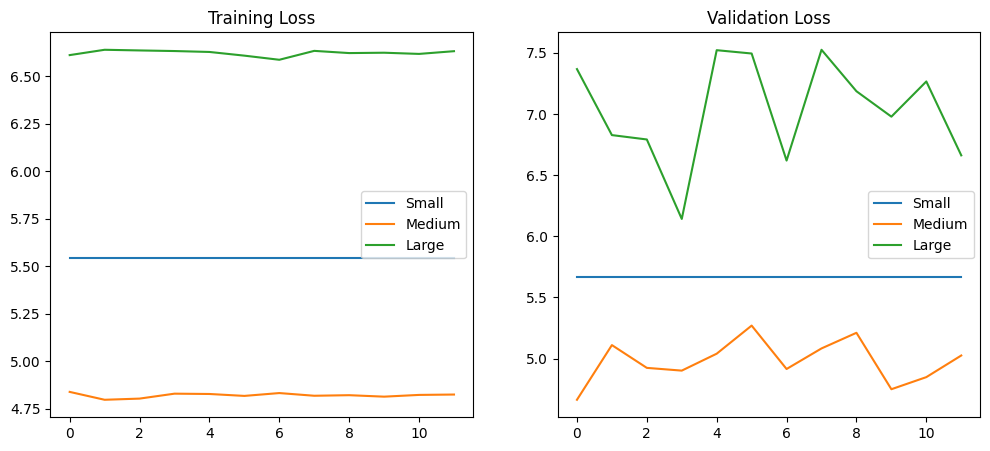

In [139]:
# 1. Вспомогательный класс для хранения параметров
class Parameter:
    def __init__(self, data):
        self.data = data
        self.grad = np.zeros_like(data)

# 2. класс MultiOutputRegressor
class MultiOutputRegressor:
    def __init__(self, input_size, output_size, model_type='medium'):
        self.layers = []

        if model_type == 'small':
            self.layers.append(Linear(input_size, 64))
            self.layers.append(ReLU())
            self.layers.append(Linear(64, output_size))

        elif model_type == 'medium':
            self.layers.append(Linear(input_size, 128))
            # Инициализируем BatchNorm с указанием размера
            bn = BatchNormalization()
            bn.moving_mean = np.zeros(128)  # 128 - размер выхода предыдущего слоя
            bn.moving_variance = np.ones(128)
            self.layers.append(bn)
            self.layers.append(ReLU())
            self.layers.append(Dropout(0.3))
            self.layers.append(Linear(128, output_size))

        else:  # large
            self.layers.append(Linear(input_size, 256))
            # Первый BatchNorm
            bn1 = BatchNormalization()
            bn1.moving_mean = np.zeros(256)
            bn1.moving_variance = np.ones(256)
            self.layers.append(bn1)
            self.layers.append(ReLU())
            self.layers.append(Dropout(0.4))

            self.layers.append(Linear(256, 128))
            # Второй BatchNorm
            bn2 = BatchNormalization()
            bn2.moving_mean = np.zeros(128)
            bn2.moving_variance = np.ones(128)
            self.layers.append(bn2)
            self.layers.append(ReLU())
            self.layers.append(Dropout(0.3))

            self.layers.append(Linear(128, output_size))

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, grad_output):
        for layer in reversed(self.layers):
            grad_output = layer.backward(layer.output if hasattr(layer, 'output') else grad_output, grad_output)
        return grad_output

    def parameters(self):
        params = []
        for layer in self.layers:
            if hasattr(layer, 'getParameters'):
                layer_params = layer.getParameters()
                if layer_params:  # Если есть параметры
                    params.extend([Parameter(p) if not isinstance(p, Parameter) else p for p in layer_params])
        return params

    def train(self):
        for layer in self.layers:
            if hasattr(layer, 'training'):
                layer.training = True

    def eval(self):
        for layer in self.layers:
            if hasattr(layer, 'training'):
                layer.training = False

# 3. Adam оптимизатор
class AdamOptimizer:
    def __init__(self, params, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        self.params = params
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.t = 0

        self.m = [np.zeros_like(p.data) for p in self.params]
        self.v = [np.zeros_like(p.data) for p in self.params]

    def step(self):
        self.t += 1
        for i, param in enumerate(self.params):
            if param.grad is None:
                continue

            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * param.grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (param.grad ** 2)

            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)

            param.data -= self.lr * m_hat / (np.sqrt(v_hat) + self.eps)

    def zero_grad(self):
        for param in self.params:
            param.grad = np.zeros_like(param.grad)

# 4. Функция обучения
def train_model(model, X_train, y_train, X_val, y_val, epochs=50, batch_size=32, lr=0.01):
    optimizer = AdamOptimizer(model.parameters(), lr=lr)
    train_losses = []
    val_losses = []
    best_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        # Перемешивание данных
        perm = np.random.permutation(len(X_train))

        for i in range(0, len(X_train), batch_size):
            batch_idx = perm[i:i+batch_size]
            X_batch = X_train[batch_idx]
            y_batch = y_train[batch_idx].reshape(-1, 1)

            # Forward pass
            output = model.forward(X_batch)
            loss = np.mean((output - y_batch)**2)

            # Backward pass
            grad_output = 2 * (output - y_batch) / len(y_batch)
            model.backward(grad_output)

            # Обновление параметров
            optimizer.step()
            optimizer.zero_grad()

            epoch_loss += loss * len(y_batch)

        # Валидация
        model.eval()
        val_output = model.forward(X_val)
        val_loss = np.mean((val_output - y_val.reshape(-1, 1))**2)

        avg_train_loss = epoch_loss / len(X_train)
        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
        elif epoch > 10:
            print("Early stopping")
            break

    return train_losses, val_losses

# 5. Загрузка и подготовка данных
data = fetch_california_housing()
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# 6. Обучение моделей
input_size = X_train.shape[1]
output_size = 1

print("Training small model...")
small_model = MultiOutputRegressor(input_size, output_size, 'small')
small_losses = train_model(small_model, X_train, y_train, X_val, y_val, lr=0.01)

print("\nTraining medium model...")
medium_model = MultiOutputRegressor(input_size, output_size, 'medium')
medium_losses = train_model(medium_model, X_train, y_train, X_val, y_val, lr=0.005)

print("\nTraining large model...")
large_model = MultiOutputRegressor(input_size, output_size, 'large')
large_losses = train_model(large_model, X_train, y_train, X_val, y_val, lr=0.001)

# 7. Оценка моделей
def evaluate(model, X, y):
    model.eval()
    preds = model.forward(X)
    return mean_squared_error(y, preds), r2_score(y, preds)

print("\nTest Results:")
for name, model in [('Small', small_model), ('Medium', medium_model), ('Large', large_model)]:
    mse, r2 = evaluate(model, X_test, y_test)
    print(f"{name} Model - MSE: {mse:.4f}, R2: {r2:.4f}")

# 8. Визуализация
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(small_losses[0], label='Small')
plt.plot(medium_losses[0], label='Medium')
plt.plot(large_losses[0], label='Large')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(small_losses[1], label='Small')
plt.plot(medium_losses[1], label='Medium')
plt.plot(large_losses[1], label='Large')
plt.title('Validation Loss')
plt.legend()
plt.show()